#### <strong><font color=cornflowerblue>第三次作品：三個分類器於Yale影像資料集的評比實驗</font></strong>
學號：711331135

姓名：王宣懿

<hr>

#### <strong>作品目標</strong>： 

本作品透過實作與比較三種常見分類模型——邏輯斯回歸（Logistic Regression）、支援向量機（SVM）與多層感知器（MLP, Multilayer Perceptron）——分析其在處理高維度影像資料時的分類表現差異。研究同時應用主成分分析（PCA）進行資料降維，並結合 GridSearchCV 方法系統性調整與比較模型超參數設定，全面評估不同模型與參數組合在原始與降維資料下的分類效能。透過模型準確率及多項評估指標（如 recall、precision、f1-score），深入探討降維對於資料結構簡化與模型效能提升的影響。

<hr>

#### <strong>載入套件</strong>：

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def show_montage(X, n, m, h, w):
    '''
    X: image matrix in which each column represents an image
    n, m: image size n x m
    h, w : create an h x w montage image with figsize = (w,h)
    '''
    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h: # 影像張數不到 w x h 張，用 0 向量補齊     
        X = np.c_[X, np.zeros((X.shape[0], w*h-X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(n, m).T, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


<hr>
<hr>

#### **<font color=cornflowerblue>第 1 題：</font>**  
以Yale資料為例，分別從原始資料集與PCA處理後資料集進行羅吉斯回歸分類練習。

**資料來源:** [Yale Dataset](https://github.com/ntpuccw/InClassCoding/blob/b8fb9a04bbc026046a769792a8d9e5b109041612/data/allFaces.mat)

**公式說明:** 

- 將一組多變量資料x的線性組合依機率大小，分配到K個類別中最大的類別。由兩個候驗機率的比值取對數後，稱為對數勝算比或邏輯轉換，以此對數勝算比做為線性回歸的應變數。
$$
\log \frac{Pr(G = K - 1 \mid X = \mathbf{x})}{Pr(G = K \mid X = \mathbf{x})} 
= \beta_{(K - 1)0} + \boldsymbol{\beta}_{K - 1}^T \mathbf{x}
$$

- 此外，也可寫成:
$$
Pr(G = k \mid X = \mathbf{x}) = 
\frac{e^{\beta_{k0} + \boldsymbol{\beta}_k^T \mathbf{x}}}
{1 + \sum_{l=1}^{K-1} e^{\beta_{l0} + \boldsymbol{\beta}_l^T \mathbf{x}}},
\quad k = 1, 2, \dots, K - 1
$$


#### (1) 匯入資料，觀察資料的基本屬性。

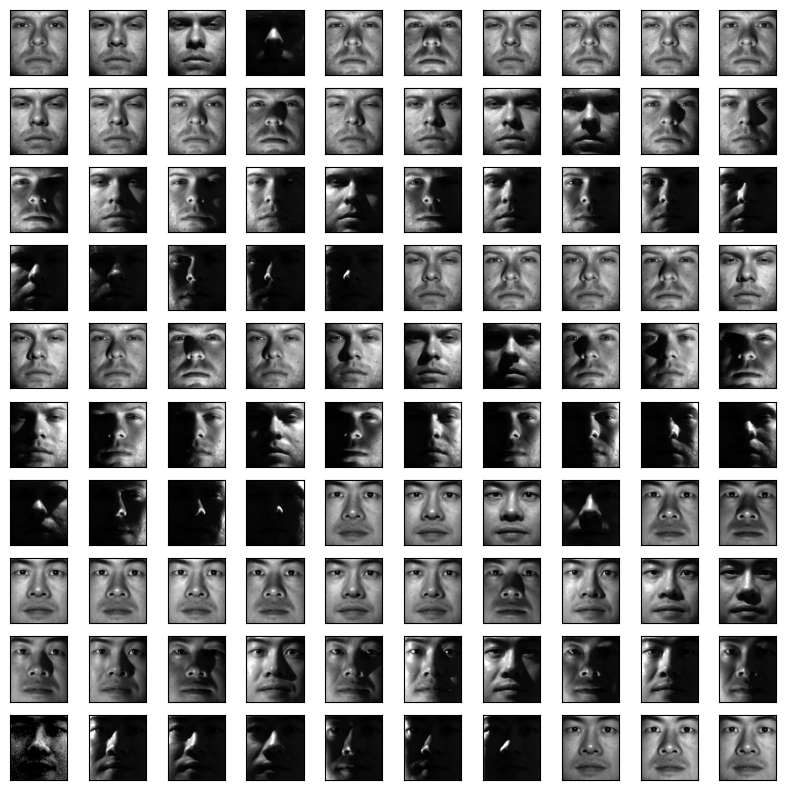


【資料集的 Keys】: ['__header__', '__version__', '__globals__', 'faces', 'n', 'm', 'sub', 'nfaces', 'person']
【X 的 Shape】: (32256, 2410)
【y 的 Shape】: (38,)
【labels 的 Shape】: (2410,)
【labels 的 Unique 值】: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


In [5]:
from scipy.linalg import svd
from PIL import Image
import numpy as np
import scipy.io

D = scipy.io.loadmat('C:/Users/user/Downloads/allFaces.mat')
X = D['faces']
y = np.ndarray.flatten(D['nfaces'])
m = D['m'].item() 
n = D['n'].item() 
n_persons = D['person'].item() 
show_montage(X,m,n,10,10)
#print(X,y)
#print(D.items)
labels = []

for person_id, count in enumerate(y):
    labels.extend([person_id] * count)

labels = np.array(labels)  
#print(labels.shape)  
print('\n【資料集的 Keys】:', list(D.keys()))
print('【X 的 Shape】:', X.shape)
print('【y 的 Shape】:', y.shape)
print('【labels 的 Shape】:', labels.shape)
print('【labels 的 Unique 值】:', np.unique(labels))

##### (2) 將資料以 7:3 的比例分為訓練集與測試集，並對自變數（X）進行標準化處理，以消除不同特徵間的量綱差異。

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X.T,labels,test_size=0.30)
scaler=StandardScaler()
x_train_=scaler.fit_transform(x_train)
x_test_=scaler.fit_transform(x_test)

##### (3) 本研究分別以經 PCA 抽取之特徵資料與原始資料作為兩組輸入變數，採用 LogisticRegression 模型並透過 Grid Search 調整最適超參數進行訓練。針對每組資料集皆使用相同的訓練集進行擬合，並於測試集上進行預測，透過準確率（accuracy）作為指標，評估模型在不同資料表示方式下的分類效能。

套件：

`from sklearn.model_selection import train_test_split`

`from sklearn.decomposition import PCA`

`from sklearn.model_selection import  GridSearchCV`

`from sklearn.linear_model import LogisticRegressionCV`

`from sklearn.metrics import accuracy_score,classification_report`

##### 2) 原始資料進行模型訓練，透過 Grid Search 方法調整分類器類型與正則化參數 C 值，尋找最佳模型組合。

In [ ]:
opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg'],#, 'sag','saga'], \
              'C':[0.1, 1, 10]} # parameters for GridSearchCV
# parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg',\
#                         'sag','saga']}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=LogisticRegression(**opts), \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy",verbose=3) 
grid.fit(x_train_, y_train)
# grid.fit(X, y)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
# print the results
# print(cv_logistic.head())
# cv_logistic.to_csv(results_file) # 打開來觀察結果
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END C=0.1, solver=lbfgs; accuracy: (test=0.937) f1_macro: (test=0.937) total time=12.4min
[CV 2/5] END C=0.1, solver=lbfgs; accuracy: (test=0.957) f1_macro: (test=0.956) total time=11.6min
[CV 3/5] END C=0.1, solver=lbfgs; accuracy: (test=0.933) f1_macro: (test=0.934) total time= 9.0min
[CV 4/5] END C=0.1, solver=lbfgs; accuracy: (test=0.943) f1_macro: (test=0.943) total time=579.0min
[CV 5/5] END C=0.1, solver=lbfgs; accuracy: (test=0.933) f1_macro: (test=0.932) total time= 9.2min
[CV 1/5] END C=0.1, solver=liblinear; accuracy: (test=0.988) f1_macro: (test=0.988) total time=35.5min
[CV 2/5] END C=0.1, solver=liblinear; accuracy: (test=0.982) f1_macro: (test=0.981) total time=34.4min
[CV 3/5] END C=0.1, solver=liblinear; accuracy: (test=0.966) f1_macro: (test=0.966) total time=32.3min
[CV 4/5] END C=0.1, solver=liblinear; accuracy: (test=0.961) f1_macro: (test=0.960) total time=33.4min
[CV 5/5] END C=0.1, solver=libli

##### 3) 原始資料使用最佳參數建立一個新的 LogisticRegression 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對分類器類型 ( lbfgs, liblinear , newton-cg )、正則化參數 C 值 ( 0.1, 1, 10 ) ，找到最佳模型組合分類器為liblinear ， 正則化參數為 0.1 。 

In [9]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=0)
solver = 'liblinear'  
Cs = [0.1] # 20 values of C from 1e-5 to 1e5
cv = 5 # 5-fold cross-validation
# --- Logistic Regression with Cross Validation ---
clf_originalCV = LogisticRegressionCV(solver = solver, Cs = Cs, cv = cv, **opts) 
clf_originalCV.fit(x_train_, y_train) # input data must be (n_samples x n_features)
y_pred = clf_originalCV.predict(x_test_)

# --- Results Report ---
# print training score
print(f"Training score = {accuracy_score(y_train, clf_originalCV.predict(x_train_)):.2%}\n")
# print testing score
# print(f"Testing score = {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Testing score = {clf_originalCV.score(x_test_, y_test):.2%}\n")
print(classification_report(y_test, y_pred,zero_division=0))

Training score = 99.82%

Testing score = 98.62%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        15
           2       0.91      0.95      0.93        21
           3       1.00      0.96      0.98        25
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        23
           7       0.93      1.00      0.97        14
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        19
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        16
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00        22
          14       1.00      1.00      1.00        14
          15       1.00      0.94      0.97        18
          16       0.95      1.0

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 測試準確率高達 98.62%，各類別的 precision、recall 與 F1-score 幾乎為 1，顯示該模型在此資料集上具備極強的分類能力與穩定性。
- class 2 與 30 的 precision 稍低（仍 > 0.87）。

##### 4) 特徵資料符合主成分總解釋變異量達 80% 以上，且邊際貢獻仍高於千分之一之最後三個特徵數作為候選範圍。隨後，透過 Grid Search 方法，同時調整分類器類型 、 正則化參數 C 值與主成分數，尋找最佳模型組合。

In [ ]:
##pca components explained ratio

pca=PCA().fit(x_train_)
cumulative=np.cumsum(pca.explained_variance_ratio_)
marginal_gain = np.diff(cumulative, prepend=0)
condition = (cumulative >= 0.8) & (marginal_gain >= 0.001)
qualified_components = (np.where(condition)[0] + 1)[-3:]  
print("符合條件的 component 編號：", qualified_components)

#pipline

opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
parameters = {
    'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg'],#, 'sag', 'saga'],
    'logreg__C': [0.1, 1, 10],
    'pca__n_components': qualified_components.tolist()
}
# parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, \
                            random_state=0) # 5-fold CV
 
pipeline = Pipeline([
    ('pca', PCA()),
    ('logreg', LogisticRegression(**opts))
])
grid = GridSearchCV(estimator=pipeline, \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy"
                ) 
grid.fit(x_train_, y_train)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
# print the results
# print(cv_logistic.head())
# cv_logistic.to_csv(results_file) # 打開來觀察結果
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_) 

In [7]:
print("符合條件的 component 編號：", qualified_components)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

符合條件的 component 編號： [47 48 49]
{'logreg__C': 0.1, 'logreg__solver': 'lbfgs', 'pca__n_components': 49}
0.873767258382643
Pipeline(steps=[('pca', PCA(n_components=49)),
                ('logreg',
                 LogisticRegression(C=0.1, max_iter=1000000, tol=1e-06))])


##### 5) 特徵資料使用最佳參數建立一個新的 LogisticRegression 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對分類器類型 ( lbfgs, liblinear , newton-cg )、正則化參數 C 值 ( 0.1, 1, 10 ) 與主成分數(47、48、49)，找到最佳模型組合分類器為lbfgs ， 正則化參數為 0.1 ， 主成分數為49 。 

In [8]:

opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=0)
solver = 'lbfgs' 
Cs = [0.1] # 20 values of C from 1e-5 to 1e5
cv = 5 # 5-fold cross-validation
# --- PCA ---
pca=PCA(n_components=49)
x_train_pca=pca.fit_transform(x_train_)
x_test_pca = pca.transform(x_test_)

# --- Logistic Regression with Cross Validation ---
clf_originalCV = LogisticRegressionCV(solver = solver, Cs = Cs, cv = cv, **opts) 
clf_originalCV.fit(x_train_pca, y_train) # input data must be (n_samples x n_features)
y_pred = clf_originalCV.predict(x_test_pca)

# --- Results Report ---

print(f"Training score = {accuracy_score(y_train, clf_originalCV.predict(x_train_pca)):.2%}\n")
# print testing score
# print(f"Testing score = {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Testing score = {clf_originalCV.score(x_test_pca, y_test):.2%}\n")
print(classification_report(y_test, y_pred,zero_division=0))

Training score = 99.82%

Testing score = 91.70%

              precision    recall  f1-score   support

           0       1.00      0.71      0.83        17
           1       0.94      0.88      0.91        17
           2       1.00      1.00      1.00        20
           3       0.80      0.94      0.86        17
           4       1.00      1.00      1.00        21
           5       1.00      0.82      0.90        17
           6       0.90      1.00      0.95        19
           7       0.84      0.89      0.86        18
           8       1.00      0.95      0.97        19
           9       0.82      0.90      0.86        20
          10       1.00      0.75      0.86        20
          11       1.00      0.94      0.97        16
          12       1.00      0.88      0.93        24
          13       1.00      0.96      0.98        24
          14       0.89      1.00      0.94        16
          15       0.95      0.95      0.95        19
          16       1.00      1.0

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 準確率超過 91%，macro F1 達 0.92，顯示模型兼具泛化與穩定性。

- 資訊壓縮造成少數類別精度下降，像 class 0、23、37 的 recall/precision 明顯未達 0.9。

##### **<font color=lightseagreen> PCA前後分類器與參數比較：</font>**  
| Model        | 分類器 | 參數 C |
|--------------|--------|--------|
| Original LR  | liblinear  | 0.1    | 
| PCA LR       | lbfgs  | 0.1    | 

- PCA 並未大幅簡化分類難度，或仍可能保留了需要被正則化的結構（如主成分之間的共線性），因此 C 不需要放寬。

- PCA 降維後的資料更適合使用基於梯度與連續優化的 lbfgs 解法，因為資料已被壓縮到較「光滑」的空間，而不再需要 liblinear 去處理可能的稀疏與不穩定特徵。

<hr>
<hr>

#### **<font color=cornflowerblue>第 2 題：</font>**  
以Yale資料為例，分別從原始資料集與PCA處理後資料集進行羅吉斯回歸分類練習。

**資料來源:** [Yale Dataset](https://github.com/ntpuccw/InClassCoding/blob/b8fb9a04bbc026046a769792a8d9e5b109041612/data/allFaces.mat)

**公式說明:** 

- 支援向量機的原理是在二維平面上建立一條直線，或在高維空間建立一個超平面，
$$
\mathbf{w}^T \mathbf{x} + \mathbf{b} = 0
$$ 

- 其中 x 代表變數向量
$$
\begin{bmatrix} x_1 & x_2 & \cdots & x_p \end{bmatrix}^T
$$
- 使得超平面能將兩個群組分開。

- 當面對超平面（線性）無法分開的群組資料時，可以將資料投射到更高維的空間，使得該資料在高維度空間為線性可分。這個觀念引入了非線性的核函數（kernels），改寫為一般式，
$$
\mathbf{w}^T \phi(\mathbf{x}) + \mathbf{b} = 0
$$


##### (1) 本研究分別以經 PCA 抽取之特徵資料與原始資料作為兩組輸入變數，採用 SVM 模型並透過 Grid Search 調整最適超參數進行訓練。針對每組資料集皆使用相同的訓練集進行擬合，並於測試集上進行預測，透過準確率（accuracy）作為指標，評估模型在不同資料表示方式下的分類效能。

套件：

`from sklearn.model_selection import train_test_split`

`from sklearn.decomposition import PCA`

`from sklearn.model_selection import  GridSearchCV`

`from sklearn.svm import SVC`

`from sklearn.metrics import accuracy_score,classification_report`

**注意事項：**
1. 為了保持實驗的一致性，本次實驗將使用與第一題相同的訓練集與測試集資料，並將其應用於所選的模型進行訓練與預測。

##### 1) 原始資料進行模型訓練，透過 Grid Search 方法調整核函數類型（kernel）與正則化參數 C 值，尋找最佳模型組合。

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svc=SVC()
param_grid={'C':np.logspace(-3,3,7),
            'kernel':["linear","rbf","poly","sigmoid"]}
grid=GridSearchCV(estimator=svc,param_grid=param_grid,cv=5,verbose=3)
grid.fit(x_train,y_train)
print("最佳參數 C：", grid.best_params_['C'])
print("最佳svc：", grid.best_params_['kernel'])
print("對應準確率：", grid.best_score_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END ............C=0.001, kernel=linear;, score=0.908 total time= 3.2min
[CV 2/5] END ............C=0.001, kernel=linear;, score=0.917 total time= 3.2min
[CV 3/5] END ............C=0.001, kernel=linear;, score=0.905 total time= 3.2min
[CV 4/5] END ............C=0.001, kernel=linear;, score=0.896 total time= 3.1min
[CV 5/5] END ............C=0.001, kernel=linear;, score=0.893 total time= 3.2min
[CV 1/5] END ...............C=0.001, kernel=rbf;, score=0.071 total time= 6.6min
[CV 2/5] END ...............C=0.001, kernel=rbf;, score=0.053 total time= 6.7min
[CV 3/5] END ...............C=0.001, kernel=rbf;, score=0.056 total time= 6.7min
[CV 4/5] END ...............C=0.001, kernel=rbf;, score=0.062 total time= 6.7min
[CV 5/5] END ...............C=0.001, kernel=rbf;, score=0.042 total time= 6.7min
[CV 1/5] END ..............C=0.001, kernel=poly;, score=0.071 total time= 6.4min
[CV 2/5] END ..............C=0.001, kernel=poly

##### 2) 原始資料使用最佳參數建立一個新的 LogisticRegression 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對核函數類型 ( linear , rbf , poly , sigmoid )、正則化參數 C 值 ( 0.1, 1, 10 ) ，找到最佳模型組合分類器為rbf ， 正則化參數為 10 。 

In [4]:
C = 10 # SVM regularization parameter
opts = dict(probability=True, random_state=0) # default decision function shape is 'ovr'
# opts = dict(C = C, decision_function_shape = ’ovo’, \
# tol = 1e−6, max_iter = int(1e6))
clf_svm = SVC(kernel='rbf', gamma="scale", **opts)

clf_svm.fit(x_train_, y_train)
print(f"Training score = {accuracy_score(y_train, clf_svm.predict(x_train_)):.2%}\n")
# print testing score
# print(f"Testing score = {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Testing score = {clf_svm.score(x_test_, y_test):.2%}\n")
predictions = clf_svm.predict(x_test_)
print(classification_report(y_test, predictions))

Training score = 91.05%

Testing score = 86.31%

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        22
           1       1.00      0.83      0.91        18
           2       1.00      0.80      0.89        15
           3       0.89      1.00      0.94        24
           4       1.00      0.82      0.90        17
           5       0.95      0.90      0.92        20
           6       0.95      0.91      0.93        22
           7       0.88      0.88      0.88        16
           8       1.00      0.65      0.79        17
           9       1.00      0.68      0.81        19
          10       1.00      0.89      0.94        19
          11       1.00      0.86      0.92        14
          12       1.00      1.00      1.00        19
          13       0.93      0.78      0.85        18
          14       1.00      0.85      0.92        13
          15       1.00      0.90      0.95        21
          16       1.00      1.0

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 在交叉驗證中表現良好（CV 準確率 91.17%），但在測試集上的實際準確率僅 86.31%，並出現部分類別明顯失衡，說明該模型對複雜多類別資料仍有潛在優化空間。

- 類別 31、33、34 等也出現偏低的 precision 或 recall，說明對少數或邊界模糊類別的辨識力不足。

- 類別 30：precision 僅 0.47，推測模型誤判其他樣本為該類別。

- 類別 29、8、36：recall 過低，容易漏判，模型無法充分捕捉其特徵。

##### 3) 特徵資料符合主成分總解釋變異量達 80% 以上，且邊際貢獻仍高於千分之一之最後三個特徵數作為候選範圍。隨後，透過 Grid Search 方法，同時調整核函數類型 、 正則化參數 C 值與主成分數，尋找最佳模型組合。

In [ ]:

##pca components explained ratio

pca=PCA().fit(x_train_)
cumulative=np.cumsum(pca.explained_variance_ratio_)
marginal_gain = np.diff(cumulative, prepend=0)
condition = (cumulative >= 0.8) & (marginal_gain >= 0.001)
qualified_components = (np.where(condition)[0] + 1)[-3:]  
print("符合條件的 component 編號：", qualified_components)

#pipline

opts = dict(probability=True, random_state=0) # parameters for LogisticRegression
parameters = {
    'svc__kernel': ["linear","rbf","poly","sigmoid"],
    'svc__C': [0.1, 1, 10],
    'pca__n_components': qualified_components.tolist()
}
# parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, \
                            random_state=0) # 5-fold CV
 
pipeline = Pipeline([
    ('pca', PCA()),
    ('svc', SVC(**opts))
])
grid = GridSearchCV(estimator=pipeline, \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy"
                ) 
grid.fit(x_train_, y_train)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
# print the results
# print(cv_logistic.head())
# cv_logistic.to_csv(results_file) # 打開來觀察結果
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

符合條件的 component 編號： [47 48 49]
{'pca__n_components': 48, 'svc__C': 0.1, 'svc__kernel': 'linear'}
0.8757396449704142
Pipeline(steps=[('pca', PCA(n_components=48)),
                ('svc',
                 SVC(C=0.1, kernel='linear', probability=True,
                     random_state=0))])


##### 4) 特徵資料使用最佳參數建立一個新的 SVM 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 核函數類型 ( linear , rbf , poly , sigmoid )、正則化參數 C 值 ( 0.1, 1, 10 )、與主成分數( 47、48、49 ) ，找到最佳模型組合分類器為linear ， 正則化參數為 0.1 ，主成分數為 48 。 

In [5]:

opts = dict(probability=True, random_state=0)
kernel = 'linear' 
C = 0.1 # 20 values of C from 1e-5 to 1e5

# --- PCA ---
pca=PCA(n_components=48)
x_train_pca=pca.fit_transform(x_train_)
x_test_pca = pca.transform(x_test_)

# --- Logistic Regression with Cross Validation ---
SVC_originalCV = SVC(kernel = kernel, C=C, **opts) 
SVC_originalCV.fit(x_train_pca, y_train) # input data must be (n_samples x n_features)
y_pred = SVC_originalCV.predict(x_test_pca)

# --- Results Report ---

print(f"Training score = {accuracy_score(y_train, SVC_originalCV.predict(x_train_pca)):.2%}\n")
# print testing score
# print(f"Testing score = {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Testing score = {SVC_originalCV.score(x_test_pca, y_test):.2%}\n")
print(classification_report(y_test, y_pred))

Training score = 99.64%

Testing score = 92.67%

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        22
           1       1.00      0.94      0.97        18
           2       0.88      0.93      0.90        15
           3       0.92      1.00      0.96        24
           4       1.00      1.00      1.00        17
           5       0.87      1.00      0.93        20
           6       0.85      1.00      0.92        22
           7       0.88      0.94      0.91        16
           8       1.00      0.71      0.83        17
           9       0.75      0.63      0.69        19
          10       0.95      0.95      0.95        19
          11       0.93      1.00      0.97        14
          12       1.00      0.95      0.97        19
          13       1.00      0.83      0.91        18
          14       0.86      0.92      0.89        13
          15       0.86      0.90      0.88        21
          16       0.91      1.0

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 在測試資料上達到 92.67% 的準確率與 0.93 的 F1-score，展現出良好的分類穩定性與泛化能力。

- Macro 與 Weighted F1-score 均達 0.93，顯示各類別預測表現整體均衡。

- 少數類別存在 召回率偏低（漏判） 的現象，雖 precision 高但模型難以抓住所有正確樣本。

##### **<font color=lightseagreen> PCA前後分類器與參數比較：</font>**  
| Model        | 分類器 | 參數 C |
|--------------|--------|--------|
| Original SVM  | rbf  | 10    | 
| PCA SVM       | linear  | 0.1    | 

- PCA 幫助資料簡化結構、消除冗餘與雜訊特徵，導致 SVM 在新的空間中能以線性方式區分資料類別，無需再依賴非線性核。

- 原始資料雜訊與複雜性較高 → 模型需強擬合（C=10）才有好表現；
PCA 後資料較乾淨與線性 → C=0.1 即可穩定建立分類邊界，避免過度擬合。

<hr>
<hr>

#### **<font color=cornflowerblue>第 3 題：</font>**  
以Yale資料為例，分別從原始資料集與PCA處理後資料集進行羅吉斯回歸分類練習。

**資料來源:** [Yale Dataset](https://github.com/ntpuccw/InClassCoding/blob/b8fb9a04bbc026046a769792a8d9e5b109041612/data/allFaces.mat)


**公式說明:** 

- 一個典型的前饋式神經網路模型，包含一層隱藏層（Hidden Layer）。在這個模型中，輸入層（Input）包含 p 個變數，隱藏層則有 q 個神經元，輸出層（Output Layer）包含 r 個輸出變數（圖中 r = 3）。輸入變數的數量 p 和輸出變數的數量 r 會依據具體問題的需求而有所不同。例如，若用於人臉辨識，則 p 代表影像的大小（或特徵向量的維度），而 r 代表辨識的類別數。

- 假設輸入端的 p 個變數表示為 $$ x_1, x_2, \dots, x_p $$

- 輸出端的 r 個變數表示為 $$ \hat{y}_1, \hat{y}_2, \dots, \hat{y}_r $$

- 則前饋式類神經網路的輸出與輸入間的數學關係寫成
$$
\hat{y}_k = \sum_{i=1}^{q} w_{ki}^2 \left( \sum_{j=1}^{p} w_{ij}^1 x_j + b_i^1 \right) + b_k^2, \quad 1 \leq k \leq r
$$

-其中函數 g(·) 稱為激發函數（activation function），可以選擇為（−1 ≤ g(z) ≤ 1）
$$
g(z) = c_1 \frac{1 - e^{-c_2 z}}{1 + e^{-c_2 z}}
$$

##### (1) 本研究分別以經 PCA 抽取之特徵資料與原始資料作為兩組輸入變數，採用 Multilayer Perceptron 模型並透過 Grid Search 調整最適超參數進行訓練。針對每組資料集皆使用相同的訓練集進行擬合，並於測試集上進行預測，透過準確率（accuracy）作為指標，評估模型在不同資料表示方式下的分類效能。

套件：

`from sklearn.model_selection import train_test_split`

`from sklearn.decomposition import PCA`

`from sklearn.model_selection import  GridSearchCV`

`from sklearn.neural_network import MLPClassifier`

`from sklearn.metrics import accuracy_score,classification_report`

**注意事項：**
1. 為了保持實驗的一致性，本次實驗將使用與第一題相同的訓練集與測試集資料，並將其應用於所選的模型進行訓練與預測。

##### 1) 原始資料進行模型訓練，透過 Grid Search 方法調整隱藏層的結構（hidden layer size）與正則化參數 （ alpha ） ，尋找最佳模型組合。

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(256,), (512,), (512, 256)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001]  # L2正則化強度
}

grid = GridSearchCV(MLPClassifier(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(x_train_, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy: {:.2f}%".format(100 * grid.best_score_))

Best parameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (256,), 'solver': 'adam'}
Best CV accuracy: 95.26%


##### 2) 原始資料使用最佳參數建立一個新的 Multilayer Perceptron 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對隱藏層的結構 ( ( 256 , ) , ( 512 , ) , ( 512 , 256) ) 、 激勵函數 ( relu , logistic ) 、 正則化參數 alpha 值 ( 0.0001, 0.001 ) ， 找到最佳模型組合隱藏層的結構(256,) ， 激勵函數為 logistic ， 正則化參數為 0.0001 。 

accuracy for test data: 95.99%
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        18
           1       0.88      0.93      0.90        15
           2       0.95      1.00      0.98        21
           3       1.00      0.96      0.98        25
           4       1.00      1.00      1.00        14
           5       0.96      0.96      0.96        24
           6       1.00      1.00      1.00        23
           7       0.64      1.00      0.78        14
           8       1.00      1.00      1.00        19
           9       0.95      1.00      0.97        19
          10       1.00      1.00      1.00        19
          11       1.00      0.94      0.97        16
          12       1.00      1.00      1.00         9
          13       1.00      0.95      0.98        22
          14       1.00      0.93      0.96        14
          15       1.00      1.00      1.00        18
          16       0.95      1.00      0.98       

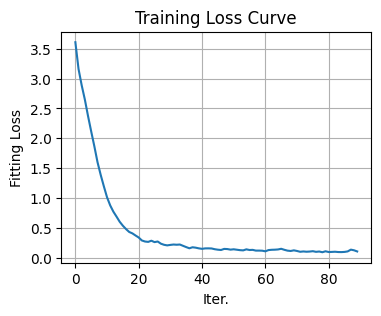

In [7]:
##pca components explained ratio
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
# hidden_layers = (512,) # one hidden layer
# activation = 'relu' # the default
hidden_layers = (256,) # one hidden layer
activation = 'logistic' # the default= 'relu'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, \
        activation = activation, tol = 1e-6, max_iter = int(1e6))
# solver = 'sgd' # not efficient, need more tuning
# solver = 'lbfgs' # not suitable here
solver = 'adam' # default solver
alpha= 0.0001
clf_MLP = MLPClassifier(solver = solver, **opts,alpha=alpha) 
clf_MLP.fit(x_train_, y_train) # X_train = (samples, features), y_train = (samples,)
predictions = clf_MLP.predict(x_test_) #output a class label for each sample
# print("accuracy for tested data: {:.2f}%".format(100*np.mean(y_test_hat == y_test)))
print("accuracy for test data: {:.2f}%".format(100*clf_MLP.score(x_test_, y_test)))
print(classification_report(y_test, predictions,zero_division=0))

fig, ax = plt.subplots(1, 1, figsize=(4,3))
plt.plot(clf_MLP.loss_curve_)
plt.grid(True)
plt.title('Training Loss Curve')
plt.xlabel('Iter.')
plt.ylabel('Fitting Loss')
plt.show()

plt.show() 

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 95.99% 的分類準確率在 38 類別中極具代表性。- logistic activation 效果優於 relu，適合中等規模且特徵明確的分類任務。 
- class 7：precision = 0.64，recall = 1.00，可能有誤判現象
- class 26、37：recall 或 precision 稍低，但整體仍 >0.80


##### 3) 特徵資料符合主成分總解釋變異量達 80% 以上，且邊際貢獻仍高於千分之一之最後三個特徵數作為候選範圍。隨後，透過 Grid Search 方法 ， 同時調整隱藏層的結構 、 正則化參數 alpha 值 、 激勵函數與主成分數 ， 尋找最佳模型組合 。

In [4]:
##pca components explained ratio
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
pca=PCA().fit(x_train_)
cumulative=np.cumsum(pca.explained_variance_ratio_)
marginal_gain = np.diff(cumulative, prepend=0)
condition = (cumulative >= 0.8) & (marginal_gain >= 0.001)
qualified_components = (np.where(condition)[0] + 1)[-3:] 
print("符合條件的 component 編號：", qualified_components)

#pipline


param_grid = {
    'mlp__hidden_layer_sizes': [(256,), (512,), (512, 256)],
    'mlp__activation': ['relu', 'logistic'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001],
    'pca__n_components': qualified_components.tolist()    # L2正則化強度
}
# parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, \
                            random_state=0) # 5-fold CV
 
pipeline = Pipeline([
    ('pca', PCA()),
    ('mlp', MLPClassifier(max_iter=1000))
])
grids = GridSearchCV(estimator=pipeline, \
                param_grid=param_grid, cv=5, 
                scoring=['accuracy','f1_macro'], refit="accuracy") 
grids.fit(x_train_, y_train)
cv_logistic = pd.DataFrame(data = grids.cv_results_)
# print the results
# print(cv_logistic.head())
# cv_logistic.to_csv(results_file) # 打開來觀察結果
print(grids.best_params_)
print(grids.best_score_)
print(grids.best_estimator_)

符合條件的 component 編號： [47 48 49]
{'mlp__activation': 'logistic', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (512, 256), 'mlp__solver': 'adam', 'pca__n_components': 49}
0.9502115779677981
Pipeline(steps=[('pca', PCA(n_components=49)),
                ('mlp',
                 MLPClassifier(activation='logistic',
                               hidden_layer_sizes=(512, 256), max_iter=1000))])


##### 4) 特徵資料使用最佳參數建立一個新的 Multilayer Perceptron 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對隱藏層的結構 ( ( 256 , ) , ( 512 , ) , ( 512 , 256) )、激勵函數 ( relu , logistic ) 、 正則化參數 alpha 值 ( 0.0001, 0.001 ) ， 主成分數 ( 47、48、49 ) ， 找到最佳模型組合隱藏層的結構 ( 512 , 256 ) ， 激勵函數為 logistic ， 正則化參數為 0.0001 ，主成分數 49 。




accuracy for test data: 92.12%
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.76      1.00      0.86        16
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        16
           4       0.95      1.00      0.98        21
           5       1.00      0.82      0.90        22
           6       0.90      0.86      0.88        21
           7       0.95      0.90      0.93        21
           8       0.82      0.93      0.88        15
           9       0.89      0.94      0.92        18
          10       0.97      0.97      0.97        33
          11       1.00      1.00      1.00        17
          12       0.94      1.00      0.97        17
          13       0.95      0.91      0.93        22
          14       0.93      0.88      0.90        16
          15       0.81      1.00      0.90        13
          16       0.88      1.00      0.94       

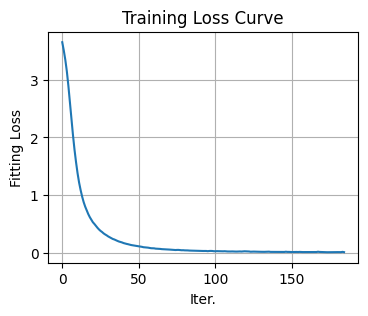

In [5]:
# --- PCA ---
pca=PCA(n_components=26)
x_train_pca=pca.fit_transform(x_train_)
x_test_pca = pca.transform(x_test_)

#-----multilayer perceptron------

hidden_layers = (512,256) # one hidden layer
activation = 'logistic' # the default= 'relu'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, \
        activation = activation, tol = 1e-6, max_iter = int(1e6))
solver = 'adam' # default solver
alpha= 0.0001
clf_MLP = MLPClassifier(solver = solver, **opts,alpha=alpha) 
clf_MLP.fit(x_train_pca, y_train) # X_train = (samples, features), y_train = (samples,)
predictions = clf_MLP.predict(x_test_pca) #output a class label for each sample
# print("accuracy for tested data: {:.2f}%".format(100*np.mean(y_test_hat == y_test)))
print("accuracy for test data: {:.2f}%".format(100*clf_MLP.score(x_test_pca, y_test)))
print(classification_report(y_test, predictions,zero_division=0))

fig, ax = plt.subplots(1, 1, figsize=(4,3))
plt.plot(clf_MLP.loss_curve_)
plt.grid(True)
plt.title('Training Loss Curve')
plt.xlabel('Iter.')
plt.ylabel('Fitting Loss')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 測試準確率與 macro F1-score 都超過 0.92，顯示整體分類準確且平衡。
- Loss curve 呈現平滑下降，表明訓練過程穩定，無過擬合現象。
- 類別：1、8、36 模型對這些類別太「寬鬆」，導致誤判過多
- 類別：5、19、20、23、33、35 模型太「保守」，雖然只預測正確的，但漏掉很多真正屬於該類的樣本

##### **<font color=lightseagreen> PCA前後分類器與參數比較：</font>**  
| Model        | 分類器 | 參數 alpha |
|--------------|--------|--------|
| Original MLP  | logistic  | 0.0001    | 
| PCA MLP       | logistic | 0.0001    | 

- MLP 模型本身需要依賴非線性激活函數來學習分類邊界，無論是否使用 PCA，logistic activation 的需求並未改變。

- 模型還是需要有高度自由度來學習資料裡的複雜關係，PCA 沒有讓資料「簡化到可以少學一點」的程度。

<hr>
<hr>

#### **<font color=cornflowerblue>PCA 降維前後分類器準確率比較：</font>** 

| Model      | Accuracy | Macro avg Precision | Macro avg Recall | Macro avg F1-score | Weighted avg Precision | Weighted avg Recall | Weighted avg F1-score |
|------------------------|----------|---------------------|------------------|--------------------|------------------------|---------------------|-----------------------|
| Original LR | 0.99     | 0.99                | 0.99             | 0.99               | 0.99                   | 0.99                | 0.99                  |
| PCA LR     | 0.92     | 0.92                | 0.92             | 0.92               | 0.92                   | 0.92                | 0.92                  |
| Original SVM | 0.86     | 0.91                | 0.86             | 0.87               | 0.91                   | 0.86                | 0.87                  |
| PCA SVM     | 0.93     | 0.93                | 0.93             | 0.93               | 0.93                   | 0.93                | 0.93                  |
| Original MP | 0.96     | 0.96                | 0.96             | 0.96               | 0.97                   | 0.96                | 0.96                  |
| PCA MP     | 0.92     | 0.92                | 0.92             | 0.92               | 0.93                   | 0.92                | 0.92                  |

##### **<font color=lightseagreen>注意事項與討論：</font>**  

##### 1 ) Logistic Regression

- 效能最佳的模型：原始資料下的 LR 在所有指標上幾乎滿分，說明資料本身與標籤的邏輯邊界相當清楚。

- 降維影響明顯：使用 PCA 後，所有評估指標下降至 0.92，表示 LR 對於資訊壓縮較敏感，分類性能部分喪失。

結論：LR 是線性模型，對於關鍵區別特徵的保留非常依賴；若 PCA 壓縮掉邊界特徵，會影響效果。

##### 2 ) SVM

- PCA 大幅提升表現：原始資料下的 SVM 效能相對較差，PCA 後明顯改善所有指標。

結論：PCA 幫助消除冗餘維度，讓 SVM 能在更緊湊的特徵空間中做出更清晰的決策邊界。

##### 3 ) Multilayer Perceptron

- 效能優異、泛化能力強：即使在未降維下，MP 表現依然穩定，僅次於原始 LR。

- PCA 有輕微負面影響：從 0.96 降至 0.92，說明 MP 能有效處理原始高維特徵，降維反而削弱了部分資訊。

結論： MP 模型原本就能聰明地從原始資料中找到分類線索，不太需要先用 PCA 幫它簡化資料，甚至可能會因為降維而錯過重要資訊，導致效能稍微下降。
